### Dataset - Bioactivity data MAP Kinase ERK2 ChEMBL

### Chemical Diversity Analysis - Bemis-Murcko Clustering

### Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs
from molvs import standardize_smiles

In [2]:
x=pd.read_csv('erk2.csv')
print(x.shape)
x.head(3)

(23306, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL440356,NaN,0.0,243.06,0,1.09,2,O=C1CCNC(=O)c2[nH]c(Br)cc21,IC50,'=',...,MAP kinase ERK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1135814,1.0,Scientific Literature,J. Med. Chem.,2002.0,None,NaN
1,CHEMBL260417,NaN,0.0,373.21,0,3.44,SB-725317,O=C(Nc1n[nH]c2nc(-c3ccc(O)cc3)c(Br)cc12)C1CC1,Inhibition,'=',...,MAP kinase ERK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1961873,16.0,GSK Published Kinase Inhibitor Set,NaN,NaN,None,NaN
2,CHEMBL213451,NaN,0.0,323.33,0,3.62,43,CCNc1nnc2ccc(-c3ocnc3-c3ccc(F)cc3)cn12,IC50,'>',...,MAP kinase ERK2,Homo sapiens,SINGLE PROTEIN,CHEMBL1145312,1.0,Scientific Literature,Bioorg. Med. Chem. Lett.,2006.0,None,NaN


In [3]:
x.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

In [4]:
x1=x[['Molecule ChEMBL ID','Smiles', 'Standard Type', 'Standard Value','Standard Units']]
x1=x1[x1['Standard Units'].str.contains('nM', na=False)]
print(x1.shape)
x1.head(3)

(18975, 5)


,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
0,CHEMBL440356,O=C1CCNC(=O)c2[nH]c(Br)cc21,IC50,539.0,nM
2,CHEMBL213451,CCNc1nnc2ccc(-c3ocnc3-c3ccc(F)cc3)cn12,IC50,10000.0,nM
4,CHEMBL214198,CC(C)c1nnc2ccc(-c3c[nH]nc3-c3cc(F)ccc3F)cn12,IC50,10000.0,nM


### Check for duplicates

In [5]:
x1.duplicated().value_counts()

False    18810
True       165
dtype: int64

In [6]:
x1.drop_duplicates(inplace=True)
x1.shape

(18810, 5)

### Check for missing values

In [7]:
x1.isnull().apply(pd.value_counts)

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
False,18810.0,18762,18810.0,18806,18810.0
True,NaN,48,NaN,4,NaN


In [8]:
x1.dropna(inplace=True)
x1.shape

(18758, 5)

### Groupby Molecule ChEMBL ID and store the mean of Standard Value in a new column

In [9]:
x1['NewStandardValue']=x1.groupby('Molecule ChEMBL ID')['Standard Value'].transform('mean')
x1.drop_duplicates('Molecule ChEMBL ID', keep='first', inplace=True)
x1.drop(['Standard Type', 'Standard Value', 'Standard Units'], axis=1, inplace=True)
x1=x1.sort_values(['NewStandardValue'], ascending=True).reset_index(drop=True)
print(x1.shape)
x1.head(3)

(17739, 3)


,Molecule ChEMBL ID,Smiles,NewStandardValue
0,CHEMBL4868141,Nc1ncc(-c2ccc(NS(=O)(=O)C3CC3)cc2OC2CCCCC2)cc1...,-29600.00000
1,CHEMBL4115001,Nc1ncc([C@@H]2CC[C@@H](O)[C@H](O)C2)nc1-c1ccc(...,0.00431
2,CHEMBL4111166,NC[C@@H](NC(=O)c1ccc(-c2nc([C@@H]3CC[C@@H](O)[...,0.00500


### Standardize smiles

In [10]:
stdsmi=[standardize_smiles(smi) for smi in x1['Smiles'] if smi is not None]

In [12]:
stdsmi=pd.DataFrame(stdsmi)
stdsmi.columns=['STD_Smiles']
combined=pd.concat([stdsmi,x1[['Molecule ChEMBL ID','NewStandardValue']]], axis=1)
combined.head(3)

,STD_Smiles,Molecule ChEMBL ID,NewStandardValue
0,Nc1ncc(-c2ccc(NS(=O)(=O)C3CC3)cc2OC2CCCCC2)cc1...,CHEMBL4868141,-29600.00000
1,Nc1ncc([C@@H]2CC[C@@H](O)[C@H](O)C2)nc1-c1ccc(...,CHEMBL4115001,0.00431
2,NC[C@@H](NC(=O)c1ccc(-c2nc([C@@H]3CC[C@@H](O)[...,CHEMBL4111166,0.00500


### Generate Murcko Scaffolds

In [13]:
mols=[Chem.MolFromSmiles(smi) for smi in combined['STD_Smiles']]

In [14]:
scaffolds=[MurckoScaffold.GetScaffoldForMol(mol) for mol in mols]

In [15]:
murcko_smi=[Chem.MolToSmiles(mol) for mol in scaffolds]

In [16]:
murcko_smi=pd.DataFrame(murcko_smi)
murcko_smi.columns=['Murcko_Smiles']
combined=pd.concat([murcko_smi,combined], axis=1)
combined.head(3)

,Murcko_Smiles,STD_Smiles,Molecule ChEMBL ID,NewStandardValue
0,O=C1NCCc2cc(-c3cncc(-c4ccc(NS(=O)(=O)C5CC5)cc4...,Nc1ncc(-c2ccc(NS(=O)(=O)C3CC3)cc2OC2CCCCC2)cc1...,CHEMBL4868141,-29600.00000
1,O=C(NCc1ccccc1)c1ccc(-c2cncc(C3CCCCC3)n2)cc1,Nc1ncc([C@@H]2CC[C@@H](O)[C@H](O)C2)nc1-c1ccc(...,CHEMBL4115001,0.00431
2,O=C(NCc1ccccc1)c1ccc(-c2cncc(C3CCCCC3)n2)cc1,NC[C@@H](NC(=O)c1ccc(-c2nc([C@@H]3CC[C@@H](O)[...,CHEMBL4111166,0.00500


In [17]:
combined.to_csv('Combined.csv', index=None)

### Images - Original Molecular Structure Vs Scaffolds

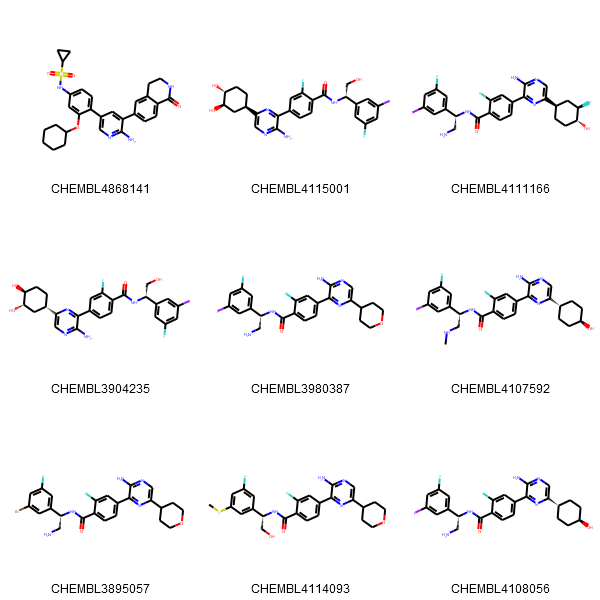

In [17]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in combined['STD_Smiles'].iloc[0:9]],legends=[x for x in combined['Molecule ChEMBL ID'].iloc[0:9]])

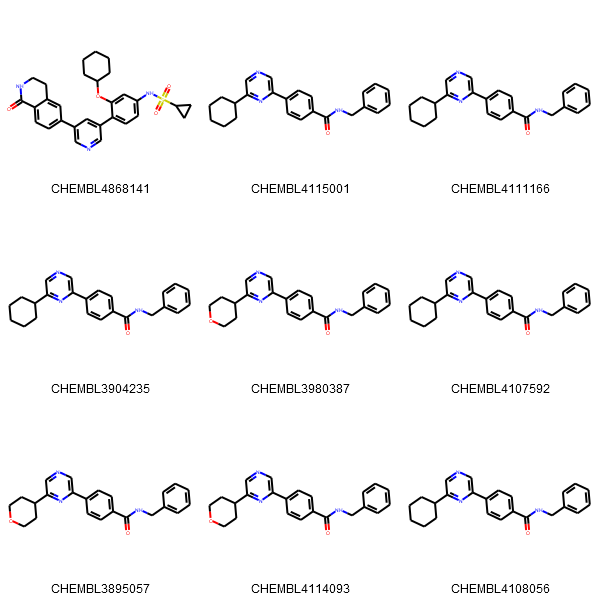

In [18]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in combined['Murcko_Smiles'].iloc[0:9]],legends=[x for x in combined['Molecule ChEMBL ID'].iloc[0:9]])

### Bemis-Murcko Clustering using MayaChem Tools

In [19]:
combined[['Murcko_Smiles','Molecule ChEMBL ID']].to_csv('murcko.smi', sep='\t', index=None, header=None)

In [20]:
!python "C:/Users/ramya_cq41ur2/Desktop/AIML-CHEM-MATERIAL INFORMATICS/Uresearcher/mayachemtools/bin/RDKitClusterMolecules.py" --infileParams "smilesColumn,1,smilesNameColumn,2,smilesDelimiter,tab,smilesTitleLine,auto,sanitize,yes" -i murcko.smi -o murcko_cluster.smi --overwrite


RDKitClusterMolecules.py (RDKit v2019.03.2; MayaChemTools v2022.24.10; Tue Dec 20 10:36:24 2022): Starting...

Processing options...

Reading file murcko.smi...
Total number of molecules: 17739
Number of valid molecules: 17689
Number of ignored molecules: 50

Generating Morgan IntVect fingerprints...

Clustering molecules using Butina methodology and Tanimoto similarity metric...
Generating file murcko_cluster.smi...

Total number of clusters: 4503

Number of clusters containing only a single molecule: 2600
Average number of molecules per cluster: 3.9

Number of molecules in each cluster:
ClusterNumber,MolCount
1,1177
2,94
3,26
4,139
5,24
6,539
7,3
8,30
9,1
10,7
11,434
12,4
13,254
14,234
15,175
16,3
17,84
18,21
19,148
20,33
21,2
22,23
23,114
24,8
25,82
26,137
27,35
28,61
29,16
30,11
31,117
32,79
33,35
34,2
35,4
36,107
37,37
38,66
39,11
40,98
41,82
42,35
43,15
44,55
45,64
46,1
47,15
48,31
49,38
50,41
51,63
52,1
53,42
54,13
55,15
56,30
57,55
58,32
59,8
60,11
61,31
62,20
63,35
64,73
65,2

### Analyze murcko_cluster

In [18]:
clus=pd.read_csv('murcko_cluster.smi', sep=' ')
clus.head(3)

,SMILES,Name,ClusterNumber
0,O=C(NCc1ccccc1)Nc1cc2[nH]nc(-c3ccncc3)c2cn1,CHEMBL3658706,1
1,O=C(NCc1ccccc1)Nc1cc2[nH]nc(-c3ccncc3)c2cn1,CHEMBL3658845,1
2,O=C(NCc1ccccc1)Nc1cc2[nH]nc(-c3ccc(=O)[nH]c3)c...,CHEMBL3654722,1


In [19]:
distribution=clus['ClusterNumber'].value_counts().reset_index()
distribution.columns=['ClusterNumber', 'Count']
distribution.head()

,ClusterNumber,Count
0,1,1177
1,6,539
2,11,434
3,13,254
4,14,234


### Get original smiles ---> correlate with ClusterNumber

In [20]:
combined=combined.rename(columns={'Molecule ChEMBL ID':'Name'})
x2=pd.merge(clus,combined, on='Name')
x2.drop(['SMILES'], axis=1, inplace=True)
x2.head(5)

,Name,ClusterNumber,Murcko_Smiles,STD_Smiles,NewStandardValue
0,CHEMBL3658706,1,O=C(NCc1ccccc1)Nc1cc2[nH]nc(-c3ccncc3)c2cn1,Cc1cc(-c2n[nH]c3cc(NC(=O)N[C@@H](C)c4ccc(Cl)c(...,722.7000
1,CHEMBL3658845,1,O=C(NCc1ccccc1)Nc1cc2[nH]nc(-c3ccncc3)c2cn1,Cc1cc(-c2n[nH]c3cc(NC(=O)N[C@H](CN)c4ccccc4)nc...,0.1524
2,CHEMBL3654722,1,O=C(NCc1ccccc1)Nc1cc2[nH]nc(-c3ccc(=O)[nH]c3)c...,C[C@@H](NC(=O)Nc1cc2[nH]nc(-c3ccc(=O)n(C)c3)c2...,0.1588
3,CHEMBL3663068,1,O=C(NCc1ccccc1)Nc1cc2[nH]nc(-c3ccncc3)c2cn1,Cc1cc(-c2n[nH]c3cc(NC(=O)NCc4cccc(S(C)(=O)=O)c...,0.1591
4,CHEMBL3654812,1,O=C(Nc1cc2[nH]nc(-c3ccncc3)c2cn1)N[C@@H]1CNC[C...,Cc1cc(-c2n[nH]c3cc(NC(=O)N[C@@H]4CN(C)C[C@H]4c...,0.1709


In [21]:
x2.to_csv('Chemical Clustering.csv', index=None)

### ClusterNumber 1 -> Original structure 

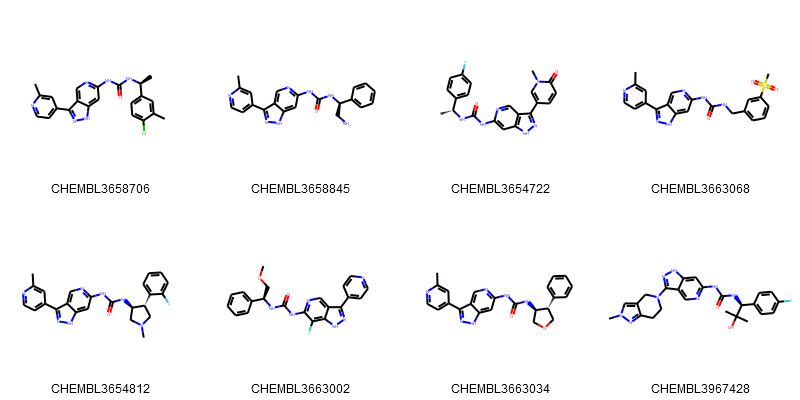

In [22]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in x2['STD_Smiles'].iloc[0:8]], molsPerRow=4,legends=[x for x in x2['Name'].iloc[0:8]])

### ClusterNumber 1 -> Scaffold 

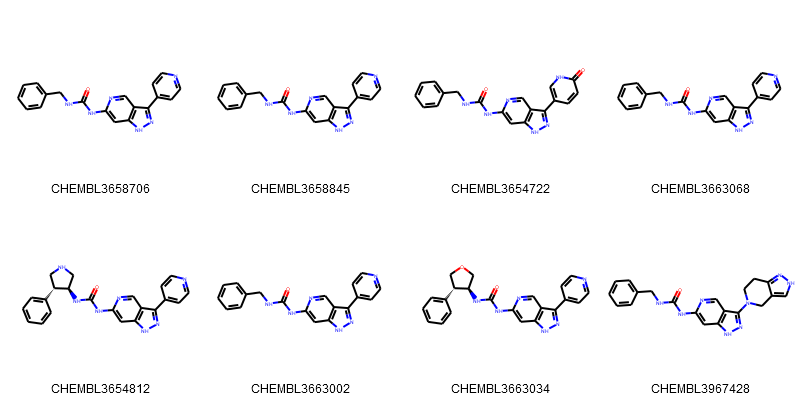

In [23]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in x2['Murcko_Smiles'].iloc[0:8]], molsPerRow=4,legends=[x for x in x2['Name'].iloc[0:8]])

### Train/Test split

### Train -> Cluster Count >= 5
### Test -> Cluster Count < 5

In [24]:
train=x2.groupby('ClusterNumber').filter(lambda x: len(x) >= 5)
test=x2.groupby('ClusterNumber').filter(lambda x: len(x) < 5)

In [25]:
print('Train Data:', train.shape)
print('Test Data:', test.shape)

Train Data: (11914, 5)
Test Data: (5775, 5)


In [26]:
train[['STD_Smiles', 'Name']].to_csv('train.smi', sep='\t', header=None, index=None)
test[['STD_Smiles', 'Name']].to_csv('test.smi', sep='\t', header=None, index=None)

### Generate Morgan Fingerprint

In [27]:
Xtrain=Chem.SmilesMolSupplier('train.smi', delimiter='\t', titleLine=False)
Xtest=Chem.SmilesMolSupplier('test.smi', delimiter='\t', titleLine=False)

In [28]:
Xtrain_fp=[AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in Xtrain if mol is not None]
Xtest_fp=[AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in Xtest if mol is not None]

In [29]:
Xtrain_id=[mol.GetProp('_Name') for mol in Xtrain if mol is not None]
Xtest_id=[mol.GetProp('_Name') for mol in Xtest if mol is not None]

### Calculate Tanimoto Similarity

In [30]:
tc=[]

for i,fp1 in enumerate(Xtrain_fp):
    for j,fp2 in enumerate(Xtest_fp):
        sim=round(DataStructs.TanimotoSimilarity(fp1,fp2), 2)
        tc.append(sim)

In [31]:
TC=pd.DataFrame(tc) 
TC.columns=['Tanimoto']

In [32]:
k,l=[],[]

for i,id1 in enumerate(Xtrain_id):
    for j,id2 in enumerate(Xtest_id):
        k.append(id1)
        l.append(id2)

In [33]:
k=pd.DataFrame(k)
k.columns=['Xtrain_IDs']

l=pd.DataFrame(l)
l.columns=['Xtest_IDs']

In [35]:
similarity=pd.concat([k,l,TC], axis=1)
similarity.sort_values(['Tanimoto'], ascending=False, inplace=True)
similarity=similarity.reset_index(drop=True)
similarity.head(10)

,Xtrain_IDs,Xtest_IDs,Tanimoto
0,CHEMBL1256708,CHEMBL1435422,1.00
1,CHEMBL1789985,CHEMBL1545634,1.00
2,CHEMBL1315821,CHEMBL1435422,0.98
3,CHEMBL1607452,CHEMBL1372136,0.98
4,CHEMBL1448251,CHEMBL566064,0.98
5,CHEMBL416288,CHEMBL1435422,0.95
6,CHEMBL1379036,CHEMBL1533639,0.95
7,CHEMBL1385322,CHEMBL1312872,0.95
8,CHEMBL53,CHEMBL1435422,0.95
9,CHEMBL1340480,CHEMBL1392663,0.94
